In [1]:
import pandas as pd

df = pd.read_csv("list_attr_celeba.csv", encoding="utf-8")

In [2]:
for col in df.columns:
    if col != "image_id":
        df[col] = (df[col] + 1) // 2

df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [3]:
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [4]:
columns_1 = ['image_id', 'Attractive']
X = df.drop(columns=columns_1, errors='ignore')
Y = df["Attractive"]
G = df["Male"]  # Cinsiyet bilgisi
H = df["Young"]  # Yaş bilgisi

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test, G_train, G_test, H_train, H_test = train_test_split(X, Y, G, H, test_size=0.2, random_state=24)

## Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, in_features=39, h1=20, h2=10, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x

model = Model()

In [7]:
CrossEntropy = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
Y_train = torch.LongTensor(Y_train.values)
Y_test = torch.LongTensor(Y_test.values)
G_test = G_test.reset_index(drop=True)
H_test = H_test.reset_index(drop=True)

## Train

In [9]:
from sklearn.metrics import accuracy_score

epochs = 200
eval_interval = 5
losses = []
val_losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    
    loss = CrossEntropy(y_pred, Y_train)
    losses.append(loss.detach().numpy())

    if i % eval_interval == 0:
        # val loss evaluation
        with torch.no_grad():
            y_eval = model.forward(X_test)
            val_loss = CrossEntropy(y_eval, Y_test)
            val_losses.append(val_loss)

            # Tahminleri al (etiketler: 0 veya 1)
            predictions = torch.argmax(y_eval, dim=1).numpy()

            # Cinsiyete göre ayır
            female_idx = (G_test == 0).values
            male_idx = (G_test == 1).values

            # Cinsiyete göre ayır
            old_idx = (H_test == 0).values
            young_idx = (H_test == 1).values

            female_acc = accuracy_score(Y_test.numpy()[female_idx], predictions[female_idx])
            male_acc = accuracy_score(Y_test.numpy()[male_idx], predictions[male_idx])

            old_acc = accuracy_score(Y_test.numpy()[old_idx], predictions[old_idx])
            young_acc = accuracy_score(Y_test.numpy()[young_idx], predictions[young_idx])

            print(f"Epoch {i}:")
            print(f"  Train Loss       : {loss.item():.4f}")
            print(f"  Validation Loss  : {val_loss.item():.4f}")
            #print(f"  Female Accuracy  : {female_acc:.4f}")
            #print(f"  Male Accuracy    : {male_acc:.4f}")
            #print(f"  Old Accuracy  : {old_acc:.4f}")
            #print(f"  Young Accuracy    : {young_acc:.4f}")
            print("-" * 40)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0:
  Train Loss       : 0.6950
  Validation Loss  : 0.6945
----------------------------------------
Epoch 5:
  Train Loss       : 0.6730
  Validation Loss  : 0.6735
----------------------------------------
Epoch 10:
  Train Loss       : 0.6337
  Validation Loss  : 0.6358
----------------------------------------
Epoch 15:
  Train Loss       : 0.5908
  Validation Loss  : 0.5943
----------------------------------------
Epoch 20:
  Train Loss       : 0.5576
  Validation Loss  : 0.5619
----------------------------------------
Epoch 25:
  Train Loss       : 0.5389
  Validation Loss  : 0.5434
----------------------------------------
Epoch 30:
  Train Loss       : 0.5277
  Validation Loss  : 0.5316
----------------------------------------
Epoch 35:
  Train Loss       : 0.5218
  Validation Loss  : 0.5253
----------------------------------------
Epoch 40:
  Train Loss       : 0.5183
  Validation Loss  : 0.5219
----------------------------------------
Epoch 45:
  Train Loss       : 0.5157
 

## Performance

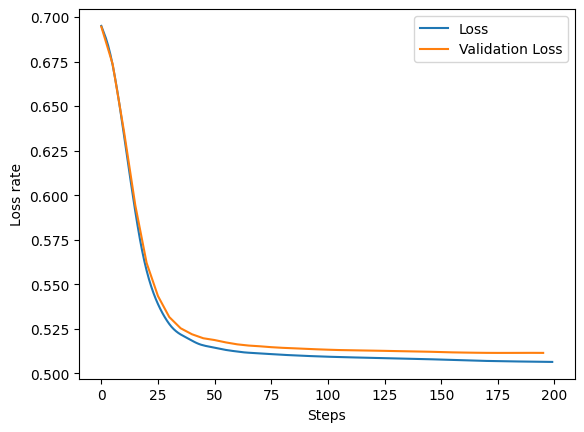

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), losses, label='Loss')
plt.plot(range(0, epochs, eval_interval), val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss rate')
plt.legend()
plt.show()

In [11]:
num_samples = 1000
random_samples = df.sample(n=num_samples, random_state=1)

# Sayaçlar
correct_predictions = {
    'female': 0,
    'male': 0,
    'young': 0,
    'old': 0
}

totals = {
    'female': 0,
    'male': 0,
    'young': 0,
    'old': 0
}

columns_1 = ['image_id', 'Attractive']

for index, row in random_samples.iterrows():
    image_id = row['image_id']
    df_target = df[df['image_id'] == image_id]

    if df_target.empty:
        print(f"image_id {image_id} için veri bulunamadı.")
        continue

    actual_label = df_target["Attractive"].values[0]
    gender = df_target["Male"].values[0]      # 0: kadın, 1: erkek
    age = df_target["Young"].values[0]        # 0: yaşlı, 1: genç

    input_row = df_target.drop(columns=columns_1, errors='ignore')
    input_tensor = torch.FloatTensor(input_row.values)

    with torch.no_grad():
        output = model(input_tensor)

    prediction = torch.argmax(output, dim=1).item()

    # Cinsiyet istatistikleri
    if gender == 0:
        totals['female'] += 1
        if prediction == actual_label:
            correct_predictions['female'] += 1
    else:
        totals['male'] += 1
        if prediction == actual_label:
            correct_predictions['male'] += 1

    # Yaş istatistikleri
    if age == 0:
        totals['old'] += 1
        if prediction == actual_label:
            correct_predictions['old'] += 1
    else:
        totals['young'] += 1
        if prediction == actual_label:
            correct_predictions['young'] += 1

    print(f"Model tahmini: {prediction} | Asıl: {actual_label} | "
          f"Cinsiyet: {'Kadın' if gender == 0 else 'Erkek'} | "
          f"Yaş: {'Genç' if age == 1 else 'Yaşlı'} | ID: {image_id}")

# Doğruluk oranlarını hesapla
def accuracy(correct, total):
    return (correct / total * 100) if total > 0 else 0

print("\n--- Sonuçlar ---")
print(f"KADINLAR için doğruluk : {accuracy(correct_predictions['female'], totals['female']):.2f}% ({correct_predictions['female']}/{totals['female']})")
print(f"ERKEKLER için doğruluk : {accuracy(correct_predictions['male'], totals['male']):.2f}% ({correct_predictions['male']}/{totals['male']})")
print(f"GENÇLER için doğruluk  : {accuracy(correct_predictions['young'], totals['young']):.2f}% ({correct_predictions['young']}/{totals['young']})")
print(f"YAŞLILAR için doğruluk : {accuracy(correct_predictions['old'], totals['old']):.2f}% ({correct_predictions['old']}/{totals['old']})")


Model tahmini: 1 | Asıl: 1 | Cinsiyet: Kadın | Yaş: Genç | ID: 057206.jpg
Model tahmini: 1 | Asıl: 0 | Cinsiyet: Kadın | Yaş: Genç | ID: 075513.jpg
Model tahmini: 0 | Asıl: 0 | Cinsiyet: Erkek | Yaş: Genç | ID: 193255.jpg
Model tahmini: 0 | Asıl: 0 | Cinsiyet: Kadın | Yaş: Genç | ID: 125592.jpg
Model tahmini: 1 | Asıl: 0 | Cinsiyet: Kadın | Yaş: Genç | ID: 075807.jpg
Model tahmini: 0 | Asıl: 0 | Cinsiyet: Erkek | Yaş: Yaşlı | ID: 093800.jpg
Model tahmini: 0 | Asıl: 0 | Cinsiyet: Erkek | Yaş: Genç | ID: 072050.jpg
Model tahmini: 0 | Asıl: 0 | Cinsiyet: Erkek | Yaş: Yaşlı | ID: 003819.jpg
Model tahmini: 1 | Asıl: 1 | Cinsiyet: Kadın | Yaş: Genç | ID: 146129.jpg
Model tahmini: 1 | Asıl: 1 | Cinsiyet: Kadın | Yaş: Genç | ID: 082920.jpg
Model tahmini: 1 | Asıl: 1 | Cinsiyet: Kadın | Yaş: Yaşlı | ID: 050103.jpg
Model tahmini: 1 | Asıl: 1 | Cinsiyet: Kadın | Yaş: Genç | ID: 037093.jpg
Model tahmini: 1 | Asıl: 0 | Cinsiyet: Kadın | Yaş: Genç | ID: 075608.jpg
Model tahmini: 0 | Asıl: 1 | Cinsiy